In [ ]:
from __future__ import annotations
from typing import Any, Dict, List, Optional, Tuple
import time
import os
from some import BaseLanguageModel, register_language_model
from some.inference import get_language_model
from some.metrics import LLMMetricsCollector, SchemaMetricsCollector
from some.prompting import BasePromptBuilder
from pydantic import BaseModel



class CustomLanguageModel(BaseLanguageModel):
    """Simple custom language model for testing."""

    def __init__(self, *, model: Optional[str] = None, **kwargs) -> None:
        super().__init__(model=model or "simple-custom")

    def generate(
        self,
        inputs: List[Dict[str, Any]],
        *,
        max_workers: Optional[int] = None,
    ) -> Tuple[List[Dict[str, Any]], int, float]:
        """Generate simple mock responses."""
        start_time = time.time()
        results = []

        for item in inputs:
            response = self._generate_single(item)
            results.append(response)
            # Simulate some processing time
            time.sleep(0.01)

        total_inference_time = time.time() - start_time
        return results, len(inputs), total_inference_time
    
    def _generate_single(self, payload: Dict[str, Any]) -> Dict[str, Any]:
        result_key = payload.get("result_key", "result")
        return {
            "input_tokens": 10,
            "output_tokens": 20,
            result_key: {},
        }

register_language_model("custom", lambda **kw: CustomLanguageModel(**kw))
    


class ProductPrompt(BasePromptBuilder):
    def build(self, item: Dict[str, Any]) -> Dict[str, Any]:
        text = item["text"]
        return {
            "messages": [{"role": "user", "content": f"Extract ProductSpec as JSON from this text and adhere strictly to the schema.\n{text}"}],
            "response_format": ProductSpec,
            "result_key": "product",
        }
    
class ProductSpec(BaseModel):
    name: str
    price: float
    features: List[str]


In [39]:
!pip install instructor

  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [instructor]


In [52]:
import instructor
import openai
from pydantic import BaseModel

# Initialize client using provider string
model = "anthropic/claude-3-haiku-20240307"
model = "openai/gpt-5-nano"

client = instructor.from_provider(model)

class User(BaseModel):
    hair_length: str
    age: int
    gender: str
    ethnicity: str
    glasses: bool

image_path = "rdj.jpg"
image = instructor.Image.from_path(image_path)

# Create structured output
user = client.chat.completions.create(
    messages=[
        {"role": "user", "content": 
         [
             "Extract physical attributes from this image and adhere strictly to the schema.",
            image
        ],
        }
    ],
    response_model=User,
)

print(user)
#> User(name='Jason', age=25)

hair_length='short' age=40 gender='male' ethnicity='Caucasian' glasses=False


In [ ]:
class WhoIsThis(BasePromptBuilder):
    def build(self, item: Dict[str, Any]) -> Dict[str, Any]:
        text = item["text"]
        image_path = item["image_path"]
        base64_image = encode_base64_content_from_path(image_path)
        return {
            "messages": [
                {
                    "role": "user", 
                    "content": 
                    [
                        {
                            "type": "text",
                            "text": f"Extract DescriptionFace as JSON from this image and adhere strictly to the schema from what you see.\n{text}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url":  f"data:image/jpg;base64,{base64_image}"
                            },
                        },
                    ]
                }
                 ],
            "response_format": DescriptionFace,
            "result_key": "description",
        }
    

    


In [31]:
import anthropic, dotenv
dotenv.load_dotenv()



client = anthropic.Anthropic()
message = client.messages.create(
    model="claude-sonnet-4-20250514",
    max_tokens=1024,
    messages=messages,
)
print(message)

Message(id='msg_01NmqipuQ2th1EsQyGJdQudJ', content=[TextBlock(citations=None, text="This image shows a person speaking at what appears to be a press conference or panel discussion. They're positioned at a microphone, wearing a dark suit jacket over a burgundy/maroon colored shirt. The person has dark hair styled in a modern cut and facial hair including a goatee. The setting appears professional, likely at a media event or conference, with the typical blurred background you'd see at such venues. The lighting and composition suggest this is from an official media appearance or interview setting.", type='text')], model='claude-sonnet-4-20250514', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation=CacheCreation(ephemeral_1h_input_tokens=0, ephemeral_5m_input_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=1552, output_tokens=105, server_tool_use=None, service_tier='standard'))


In [38]:


items = [
    {"text": "", "image_path": "rdj.jpg"},
]

# Build inputs using the prompt builder
inputs = [WhoIsThis().build(x) for x in items]

# Get language model
provider = "ollama"  # Change to "custom" if you want to test the mock model
# model = "gpt-5-nano"
model = "gemma3:4b"

lm = get_language_model(provider=provider)#, model=model)
print(lm.generate(inputs))

ERROR:root:OpenAI inference error for item 0: Error code: 404 - {'error': {'message': 'The model `gemma3:4b` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


([{'input_tokens': 0, 'output_tokens': 0, 'description': None, 'error': "Error code: 404 - {'error': {'message': 'The model `gemma3:4b` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}"}], 1, 0.7106900215148926)


[{'messages': [{'role': 'user',
    'content': [{'type': 'text',
      'text': 'Extract DescriptionFace as JSON from this image and adhere strictly to the schema from what you see.\n'},
     {'type': 'image_url',
      'image_url': {'url': ''}}]}],
  'response_format': __main__.DescriptionFace,
  'result_key': 'description'}]
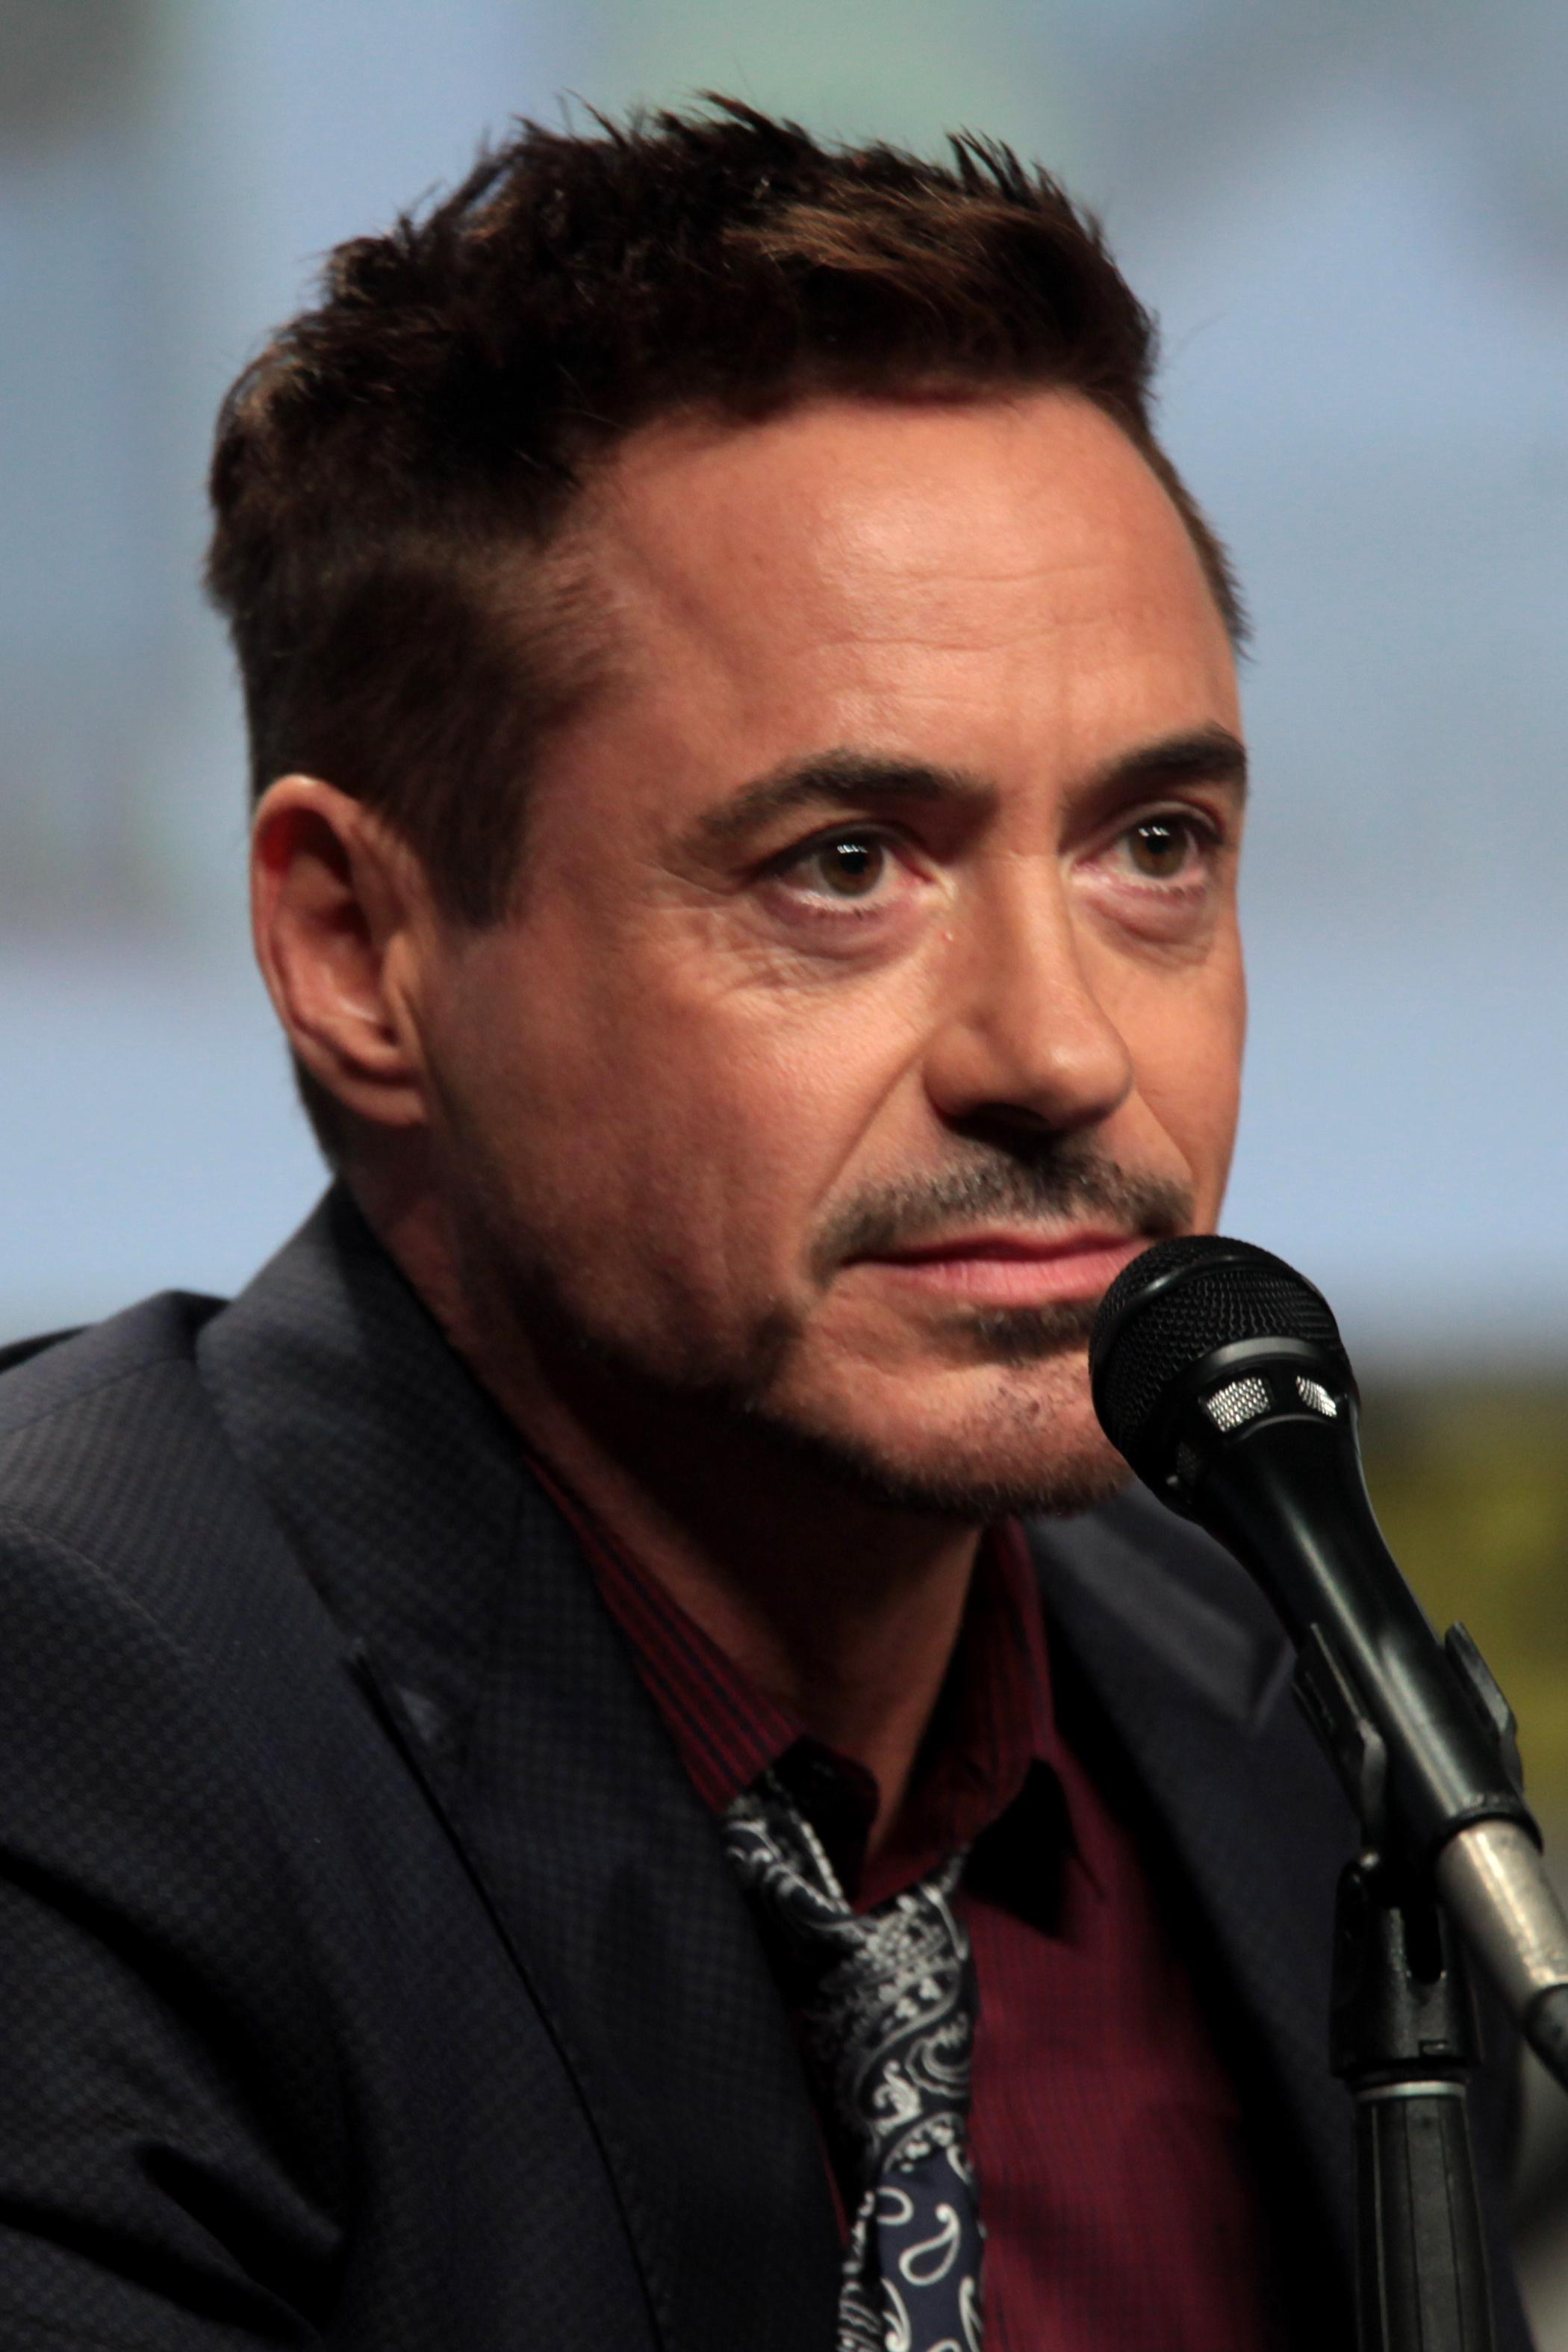

In [35]:
inputs

In [ ]:


items = [
    {"text": "Widget X costs $19.99 and includes wifi, gps."},
    {"text": "Gadget Y is priced at $49.50, features: bluetooth, waterproofing"},
    {"text": "Device Z sells for $129.00 with premium materials and AI processing"},
]

# Build inputs using the prompt builder
inputs = [ProductPrompt().build(x) for x in items]

# Get language model
provider = "mm"  # Change to "custom" if you want to test the mock model
# model = "gpt-5-nano"
lm = get_language_model(provider=provider)#, model=model)
print(lm.generate(inputs))